In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

In [2]:
df = pd.read_csv('df_cleaned.csv')

# Preprocessing

## Remove Outliers

Removing outliers before performing k-means clustering is important because k-means is sensitive to outliers. Outliers can significantly affect the clustering results, leading to less meaningful and less accurate clusters:
- Outliers can distort the centroids (means) of clusters because k-means minimizes the sum of squared distances between data points and their assigned cluster centroids. An outlier, being far from most data points, can pull the centroid towards itself, thereby distorting the actual center of the cluster.
- Outliers can lead to incorrect cluster assignments for the non-outlier data points. Since the centroid might be skewed due to the outliers, data points that should belong to a cluster might be assigned to a different cluster.
- Outliers increase the variance within clusters, making the clusters less cohesive. This reduces the quality of the clustering, as clusters should ideally have low intra-cluster variance and high inter-cluster variance.

In [3]:
# # define outliers
# q1 = df.quantile(0.25)
# q3 = df.quantile(0.75)
# iqr = q3 - q1
# outliers = (df[num_features] < (q1-1.5*iqr)) | (df[num_features] > (q3+1.5*iqr))

# #create a copy of dataframe with outliers removed
# df = df[~outliers.any(axis=1)]

## Feature Engineering

There are various family sizes of the customers, by creating categroies based on different sizes: 'Single', 'Couple', 'Small Family', and 'Large Family', it can help in identifying different family dynamics.

In [4]:
# def family_type(size):
    
#     if size == 1:
#         return 'Single'
#     elif size == 2:
#         return 'Couple'
#     elif 2 < size <= 4:
#         return 'Small Family'
#     else:
#         return 'Large Family'
    
# # apply function
# df['Family_Type'] = df['Family_Size'].apply(family_type)

In [3]:
df_original = df.copy()

## Encode Categorical Features

Look at the `Spending_Score` column, there are three values: 'Low', 'Average', and 'High'. They perserve ordinal information about how much the customers have been spending, it justifies to label encode them. `Ever_Married` and `Gender` columns can also be encoded as a binary features.

In [4]:
# define the label mappings
spending_score_mapping = {
    'Low': 1,
    'Average': 2,
    'High': 3
}

ever_married_mapping = {
    'Yes': 1,
    'No': 0
}

gender_mapping = {
    'Male': 1,
    'Female': 0
}

# apply label encoding
df['Spending_Score'] = df['Spending_Score'].map(spending_score_mapping)
df['Ever_Married'] = df['Ever_Married'].map(ever_married_mapping)
df['Gender'] = df['Gender'].map(gender_mapping)

For the rest of the categorical features, we tranform them with one-hot encoding method.

In [5]:
# list of categorical features
cat_features = df.select_dtypes(include='object').columns

df = pd.get_dummies(df, columns=cat_features, drop_first=True)

In [6]:
df.head()

,Gender,Ever_Married,Age,Work_Experience,Spending_Score,Family_Size,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,1,0,22,1.000000,1,4.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,0,1,38,2.619777,2,3.0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,1,67,1.000000,1,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,1,1,67,0.000000,3,2.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0,1,40,2.619777,3,6.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0


## Scale Numerical Features

In [7]:
# list of numerical features
num_features = ['Age', 'Work_Experience', 'Spending_Score', 'Family_Size']
num_features

['Age', 'Work_Experience', 'Spending_Score', 'Family_Size']

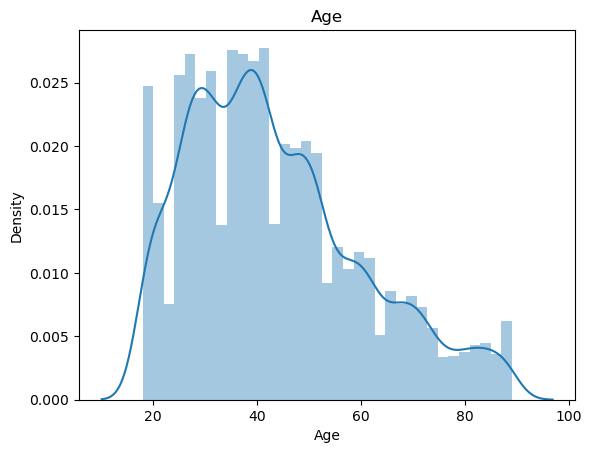

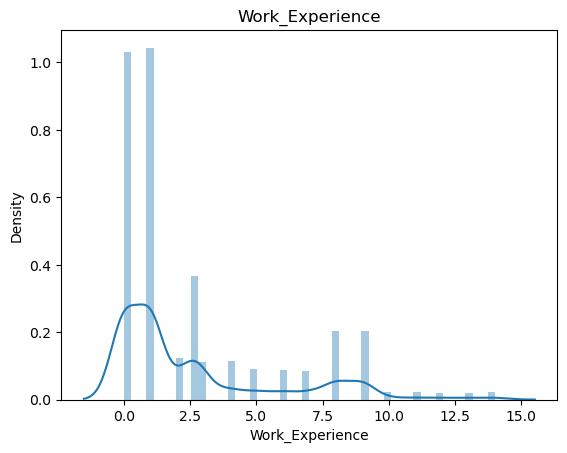

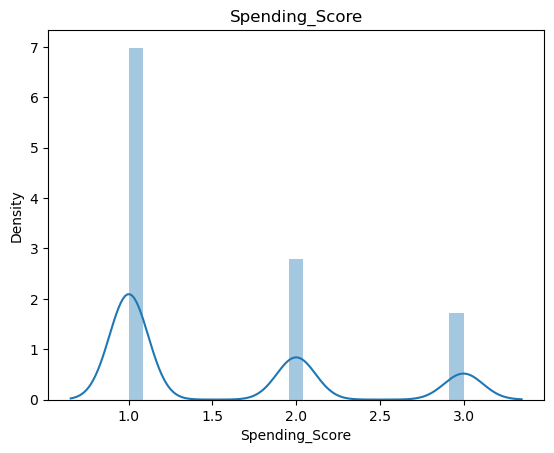

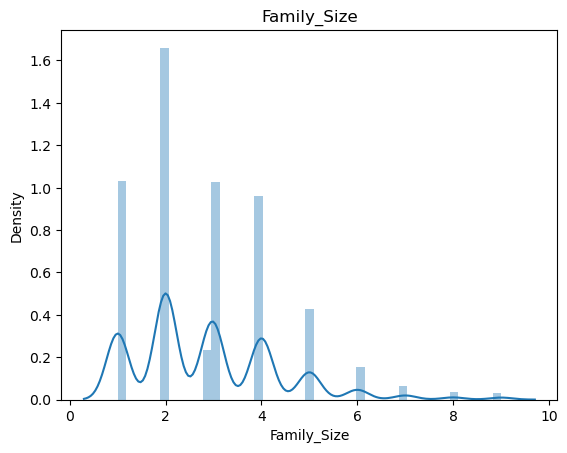

In [8]:
# look at distribution of numerical features
for col in num_features:
    
    sns.distplot(df[col])
    plt.title(f'{col}')

    plt.show()

When preparing data for clustering models, it's important to scale numerical features. Data that are on different scale can be particularly challenging because they can distort the distance calculations that many clustering algorithms rely on (like K-means). 

For `Spending_Score` column, we want to maintain the orderig and only rescale it to keep the relative distances but normalize the range.

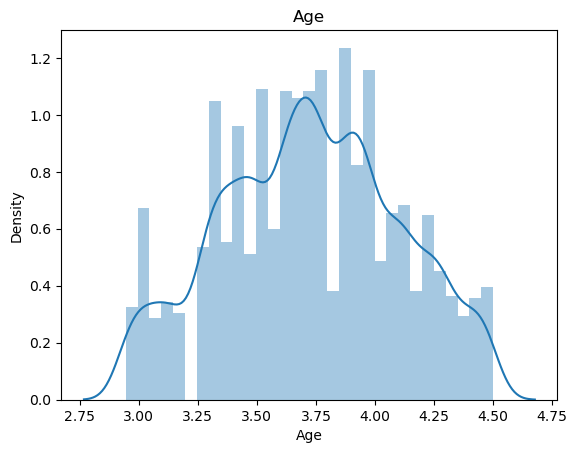

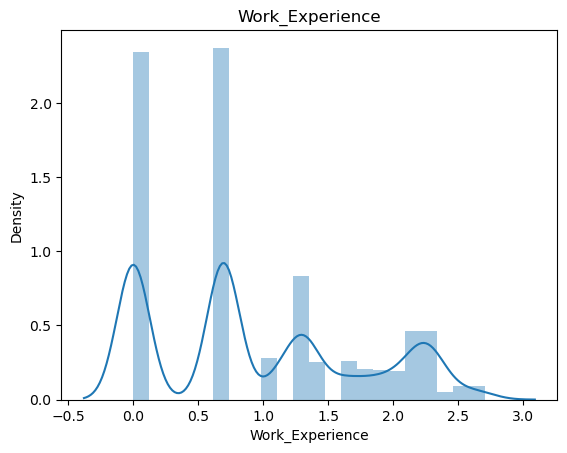

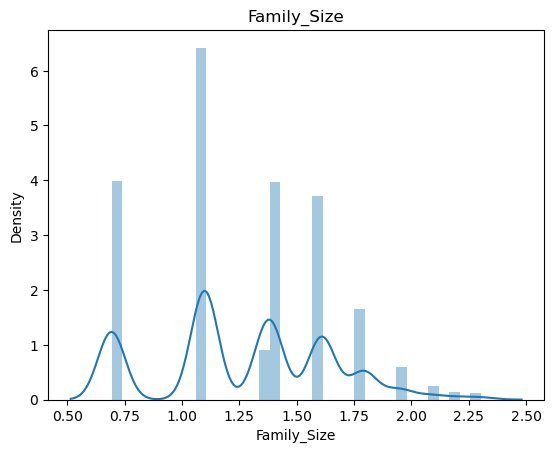

In [9]:
# apply log transformation before scaling
for col in ['Age', 'Work_Experience', 'Family_Size']:
    df[col] = np.log1p(df[col])
    
    sns.distplot(df[col])
    plt.title(f'{col}')

    plt.show()

In [10]:
# instantiate scaler
scaler = StandardScaler()

for col in ['Age', 'Work_Experience', 'Family_Size']:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))

In [11]:
# instantiate scaler for normalization
minmax = MinMaxScaler()

# scale `Spending_Score`
df['Spending_Score'] = minmax.fit_transform(df['Spending_Score'].values.reshape(-1,1))

## Feature Correlation

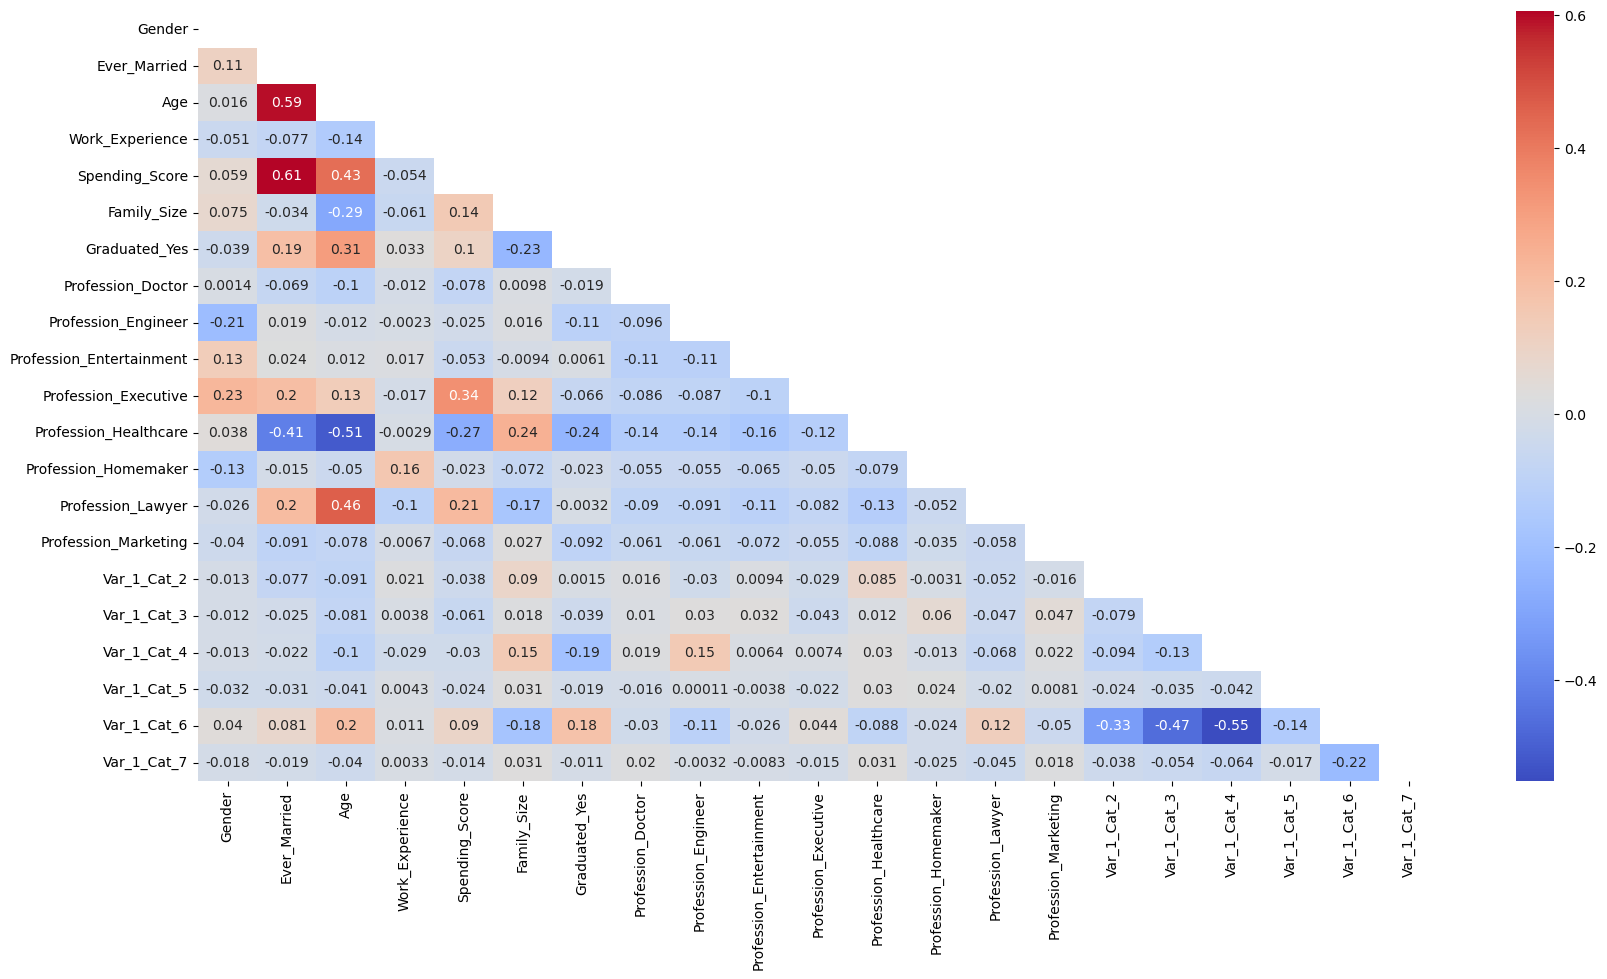

In [12]:
# get correlation matrix
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))

plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix,
           mask=mask,
           annot=True,
           cmap='coolwarm')
plt.show()

## Dimensionality Reduction

When applying PCA we need to choose the number of principal components we want to keep. A lower number means a larger reduction of the number of dimensions, however this will come at the cost of losing additional information from the components which are dropped.

The process for picking the number of PCs is as follows:

- Apply PCA to the original k-dimensional data set.
- Extract the explained variance ratios for the principal components.
- Use one of the following methods to decide how many PCs can represent the data well enough
    - Make a line plot of the explained variance ratios. Look for an elbow in the plot to decide how many PCs are sufficient, as that will tell you that adding more PCs is not substantially raising the explained variance.
    - Decide on a threshold for how much variance needs to be explained by the PCs (e.g. if I want to preserve 90% of the original dataset's variance, how many PCs do I need to include in my reduced dimension data?)

Based on your decision, re-fit a PCA object with the required number of PCs, and use that to create a lower-dimensional representation of your data for further analysis.

In [13]:
# instantiate PCA
pca = PCA()

df_pca = pd.DataFrame(pca.fit_transform(df))

Two key attributes available from the fitted PCA object are the `explained_variance_` and `explained_variance_ratio_`:

   - `explained_variance_` : Array containing the amount of variance explained by each component.
   - `explained_variance_ratio` : Array containing the _percentage_ of variance explained by each component. 

Just like the `components_` attribute, both arrays are sorted in descending order. The first value in each relates to the variance explained by the first principal component

In [14]:
pca.explained_variance_

array([1.46215513, 1.06767319, 0.75176668, 0.28978619, 0.25702662,
       0.20090291, 0.16089489, 0.11961516, 0.11577316, 0.09881953,
       0.08176626, 0.07454151, 0.06217706, 0.05662638, 0.05256697,
       0.03848401, 0.03187506, 0.02975591, 0.01990931, 0.01261118,
       0.00239999])

In [15]:
pca.explained_variance_ratio_

array([0.29318586, 0.21408582, 0.15074143, 0.05810684, 0.05153801,
       0.0402843 , 0.03226204, 0.02398478, 0.0232144 , 0.01981492,
       0.01639546, 0.01494678, 0.01246751, 0.01135451, 0.01054053,
       0.00771667, 0.00639147, 0.00596654, 0.00399214, 0.00252875,
       0.00048124])

The values given to us in `explained_variance_` are not very interpretable. But the values given in `explained_variance_ratio_` can be interpreted as the following:

* 29.3% of the variation in the data is seen in the direction of the first PC
* 21.4% of the variation in the data is seen in the direction of the second PC

We can now follow one of two methods to pick our 'optimal' number of PCs.


I will use the second method mentioned. With this method we go in with a pre-determined threshold for the proportion of variance we want to keep post dimensionality reduction. 
For example, we may state that we want to apply dimensionality reduction, but ensure that we keep enough PCs to explain 90% of variance. 

To do this we can calculate the cumulative sum of the explained variance ratio provided by each individual PC.

In [16]:
# pull out the explained variance ratio
exp_var = pca.explained_variance_ratio_

# calculate the cumulative sum of this array using the 
cumulative_sum = np.cumsum(exp_var)

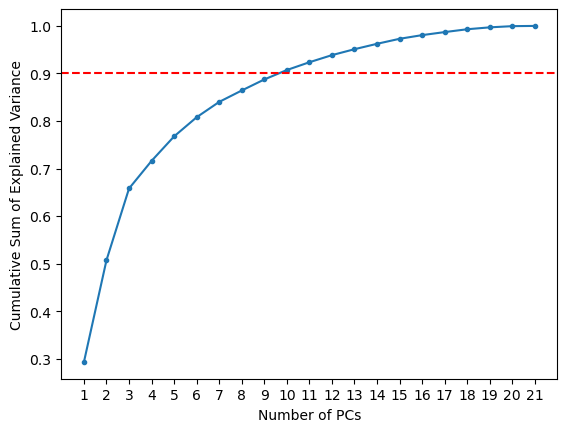

In [17]:
# plot the cumulative sum graph

plt.figure()
plt.plot(range(1,len(cumulative_sum)+1), cumulative_sum, marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.xticks(range(1,len(cumulative_sum)+1))
plt.show()

The 13th PC explains over 90% of the variation, so we choose `n-component = 10` to be our optimal number of components. 

In [18]:
# instatiate PCA with optimal n-component
pca = PCA(n_components=10)

# fit transform
df_pca = pd.DataFrame(pca.fit_transform(df))

# Modelling

## K-Means

K-means works by partitioning the dataset into K distinct, non-overlapping clusters. It aims to minimize the variance within each cluster, which is essentially the sum of the squared distances between the data points and their respective cluster centroid. When fitting a K-means model, we are minimizing the sum of squared distances between each point and its assigned cluster center. This is referred to as the _Within Sum of Squares (WSS)_ distance or the _inertia_. Formally, we can write this as:

$$\sum_{k=1}^{k}\sum_{C(i)=k} \left\lVert x_i - m_k \right\rVert^2$$
where 
- $m_k$ is the center of cluster $k$, and
- $C(i)$ is the cluster of the point $x_i$.<br>
<br>
The steps involved in K-means clustering typically include:

- Choosing the number of clusters (K): This is often based on business understanding, data inspection, or methods like the elbow method, which involves plotting the sum of squared distances to centroids for various values of K and selecting the "elbow" point.
- Initializing centroids: Initially, K points are chosen as the centroids of the clusters. The k-means++ method can be used for smarter initialization to improve convergence.
- Assigning points to the nearest cluster centroid: Each data point is assigned to the cluster whose centroid is closest to the point.
- Recomputing centroids: Once all points have been assigned to clusters, the centroids of each cluster are recalculated as the mean of all points assigned to that cluster.
- Iterating: Steps 3 and 4 are repeated until the centroids no longer move significantly, indicating that the clusters have stabilized and the algorithm has converged.

**Pick the Optimal K**

The most important parameters we are focusing on is K (the number of clusters into which the data is to be grouped). It is not automatically determined by the algorithm, so selecting an appropriate value for K can be challenging. There are two methods we can use to find the optimal K for our model:

- **The "Elbow Method"** is a popular technique used to determine the optimal number of clusters for k-means clustering, and it can also be applied to other clustering algorithms that require the user to specify the number of clusters. The method involves running the clustering algorithm multiple times over a range of values for the number of clusters (K) and plotting the results to find the point at which the improvement in the sum of squared errors (SSE) or inertia diminishes.
- **Silhouette Score** measures how similar an object is to its own cluster compared to other clusters. 
    For each point, $i$, the following quantity is measured:

    $$s_i = \frac{b_i - a_i}{max(b_i, a_i)}$$

    where:
    * $s_i$ is the silhouette score for the point $i$,
    * $a_i$ is the mean distance from point $i$ to all other points in $i$'s cluster
    * $b_i$ is the mean distance from point $i$ to all other points in the closest cluster that **isn't** $i$'s cluster
    
    The silhouette score ranges from -1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. Plotting these scores for different values of K can help identify an optimal cluster count.

In [21]:
# range of k-values to try
k_range = range(1,20)
# empty lists to store sse and silhouette score
sse = []
sil_score = []

for k in k_range:
    # instantiate K-Means
    kmeans = KMeans(n_clusters=k,
                   init='k-means++',
                   n_init=10,
                   max_iter=1000,
                   random_state=42)
    #fit model
    kmeans.fit(df_pca)
    # get sse
    sse.append(kmeans.inertia_)
    
for k in range(2,max(k_range)):
    # instantiate K-Means
    kmeans = KMeans(n_clusters=k,
                   init='k-means++',
                   n_init=10,
                   max_iter=1000,
                   random_state=42)
    #fit model
    kmeans.fit(df_pca)
    # get silhouette scores 
    labels = kmeans.labels_
    silhouettes = silhouette_score(df_pca, labels)
    sil_score.append(silhouettes)

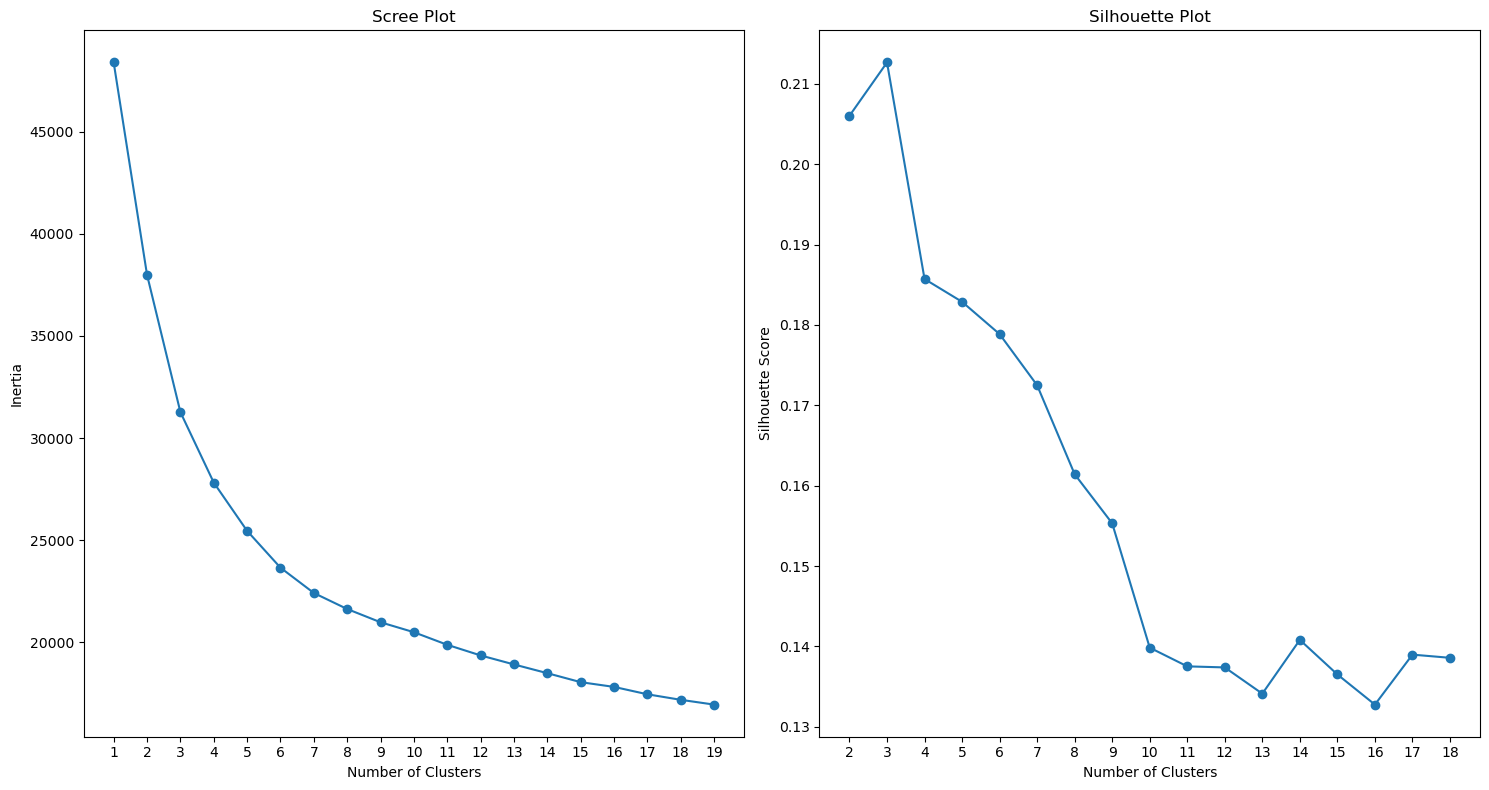

In [22]:
plt.subplots(1,2,figsize=(15,8))

# scree plot
plt.subplot(1,2,1)
plt.plot(k_range, sse, marker='o',)
plt.xticks(range(1,20))
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Scree Plot')

# silhouette plot
plt.subplot(1,2,2)
plt.plot(range(2,max(k_range)), sil_score, marker='o',)
plt.xticks(range(2,19))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Plot')

plt.tight_layout()
plt.show()

It looks like 3 clusters optimize both the inertia and silhouette score.

In [19]:
# fit model with the optimal n_clusters
kmeans = KMeans(n_clusters=3,
               max_iter=1000,
               random_state=42)

kmeans.fit(df_pca)

labels_kmeans = kmeans.predict(df_pca)

# apped the labels to the original dataset
df_original['KMeans_Labels'] = labels_kmeans

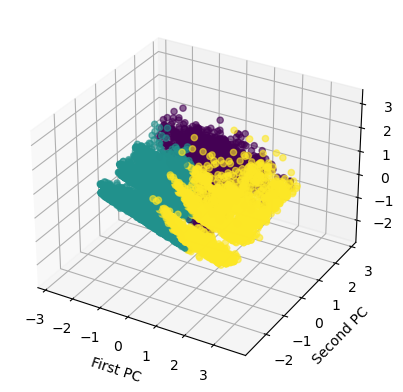

In [20]:
# visualize clusters in 3D
x = df_pca[0]
y = df_pca[1]
z = df_pca[2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # create a subplot adding Axes3D to the figure

# scatter plot
ax.scatter(x, y, z, c=labels_kmeans, alpha=0.6)

ax.set_title('')
ax.set_xlabel('First PC')
ax.set_ylabel('Second PC')
ax.set_zlabel('Third PC')

plt.show()

In [25]:
# # plotly interactive plot

# fig = px.scatter_3d(df_pca,
#                    x=0,
#                    y=1,
#                    z=2,
#                    color=labels,
#                    opacity=0.7)

# fig.show()

In [21]:
df_original.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,KMeans_Labels
0,Male,No,22,No,Healthcare,1.000000,Low,4.0,Cat_4,2
1,Female,Yes,38,Yes,Engineer,2.619777,Average,3.0,Cat_4,0
2,Female,Yes,67,Yes,Engineer,1.000000,Low,1.0,Cat_6,1
3,Male,Yes,67,Yes,Lawyer,0.000000,High,2.0,Cat_6,1
4,Female,Yes,40,Yes,Entertainment,2.619777,High,6.0,Cat_6,2


## Hierarchical Clustering

Hierarchical clustering algorithms apply either bottom-up or top-down approach to build a layered hierarchy on the data. At the most granular level, we have the individual data points as their own clusters, while on the other end, the whole data set as a single cluster. Any level in between can be considered a specific clustering of the data set.

* **Agglomerative hierarchical clustering** works bottom up, iteratively joining groups of data points that are nearby or similar with respect to some distance metric.

Agglomerative clustering is based on the following rough algorithm:

1. Initially, each data point is made to be a cluster.
2. Repeat the following until a stopping criteria is met:
    - A distance is calculated between each pairwise combination of clusters.
    - Based on the distances, the two "closest" clusters are merged to form a new cluster.
   
The *distance metric* between each pair of clusters is usually based on the Euclidean distance. But how do we calculate the distance between clusters? This methods are referred to as *linkages*.

1. **Single Linkage** calculates the shortest distance between any two points in the two clusters.
2. **Complete (Maximum) Linkage** finds the largest distance between any two points in the two clusters.
3. **Average Linkage** calculates the mean distance between the points in one cluster to every other point in the second cluster.
4. **Ward's Linkage** is a method that joins two clusters that so that the increase in variance is minimal. This is a commonly used linkage that has proven to work well in practice.

For this project I will only implement the Ward's Linkage.

To decide how many clusters we should use, the iterative process of joining together more and more clusters is often visualized by a so-called dendrogram, a type of tree diagram. The leaves in this tree correspond to individual data points. As we iteratively join the nearest points and then nearest clusters into larger groups, we are merging the leaves and branches of the tree into bigger branches. The linkage-distance between two clusters are represented by the height their merger in the dengrogram.

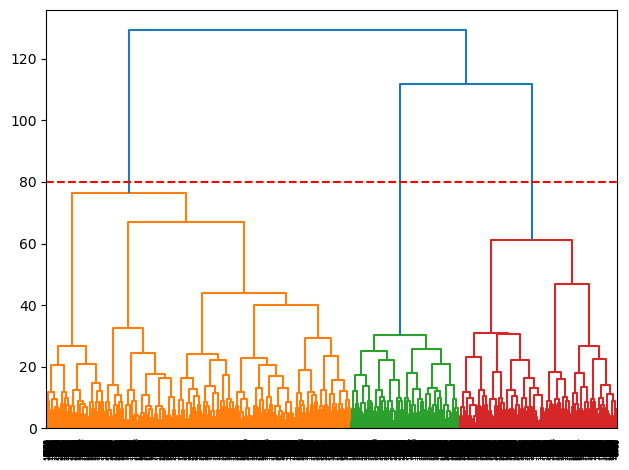

In [28]:
# plot the dendrogram
linkage_data = linkage(df_pca, method = 'ward', metric = 'euclidean')
dendrogram(linkage_data)
plt.axhline(y=80, color='red', linestyle='--')
plt.tight_layout()
plt.show()

- The large blue line near the top merges very late, suggesting a distinct separation from the rest of the data. This indicates a clear cluster on its own.
- The large gap below this line, where the red and green clusters meet, is another potential area for cutting the tree to form separate clusters.
- Drawing a line slightly lower, just above the height where the green and red clusters meet (around 80), could yiled 3 cluster.

In [37]:
# build a model with 3 clusters
agc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')

labels_agc = agc.fit_predict(df_pca)

# append class labels to the original dataset
df_original['Agc_Labels'] = labels_agc

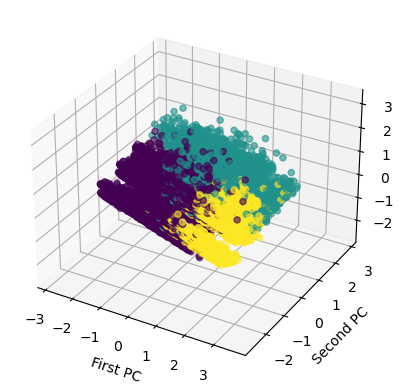

In [38]:
# visualize clusters in 3D
x = df_pca[0]
y = df_pca[1]
z = df_pca[2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # create a subplot adding Axes3D to the figure

# scatter plot
ax.scatter(x,y,z, c=labels_agc, alpha=0.6)

ax.set_title('')
ax.set_xlabel('First PC')
ax.set_ylabel('Second PC')
ax.set_zlabel('Third PC')

plt.show()

# Models Evaluation

We will look at three evaluation metrics:
- `Silhouette Score`: Measures the similarity of an object to its own cluster compared to other clusters. Ranges from -1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters
- `Calinski-Harabasz Score`: Calculates the ratio of the sum of between-cluster dispersion to within-cluster dispersion. Higher values generally indicate that clusters are dense and well-separated, which is desirable.
- `Davies-Bouldin Index`: The average 'similarity' between each cluster and its most similar one, where similarity is the ratio of within-cluster distances to between-cluster distances. Lower values indicate better clustering.

In [48]:
# empty lists to store metric scores
sil_scores = []
calinski_scores = []
davies_scores = []

for label in [labels_kmeans, labels_agc]:
    
    # append scores
    sil_scores.append(silhouette_score(df_pca, label))
    calinski_scores.append(calinski_harabasz_score(df_pca, label))
    davies_scores.append(davies_bouldin_score(df_pca, label))
    
    
# create dataframe fro metrics
metrics_df = pd.DataFrame({'Model':['KMeans','AGC'], 'Silhouette Score':sil_scores, 'Calinski-Harabasz Score': calinski_scores, 'Davies-Bouldin Index':davies_scores})
metrics_df = metrics_df.set_index('Model')

display(metrics_df)

,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Index
Model,,,
KMeans,0.212659,2926.093405,1.568628
AGC,0.179604,2311.872131,1.692858


Based on the metrics, we can see that KMeans scored higher on every metric than Agglomerative Clustering.
- `Silhouette Score`: 0.212659. This score is moderate, suggesting that while there is some separation and internal coherence within clusters, there might still be room for improvement. It indicates that clusters are not highly distinct but are reasonable.
- `Calinski-Harabasz Score`: 2926.093405. This is a relatively high score, suggesting good cluster separation and compactness, which is favorable.
- `Davies-Bouldin Index`: 1.568628. This score, being lower than AGC's, suggests better clustering performance. Lower values mean the clusters are better separated and less similar to each other.

# Cluster Analysis and Profiling

In [123]:
# list of numerical features
num_features = df_original.drop(columns=['KMeans_Labels', 'Agc_Labels']).select_dtypes(include='number').columns
num_features

Index(['Age', 'Work_Experience', 'Spending_Score', 'Family_Size'], dtype='object')

## Numerical Features Analysis

In [ ]:
# the spending score column is better to interpret as an ordinal feature
spending_score_mapping = {
    'Low': 1,
    'Average': 2,
    'High': 3
}

df_original['Spending_Score'] = df_original['Spending_Score'].map(spending_score_mapping)

In [25]:
# group the data into clusters for statistical analysis
df_original.groupby('KMeans_Labels')[num_features].mean()

,Age,Work_Experience,Spending_Score,Family_Size
KMeans_Labels,,,,
0,39.328135,6.536714,1.469808,2.259085
1,55.472102,0.779817,1.803994,2.442884
2,27.406516,1.603855,1.170680,4.158345


Let's visualize this in a radar chart for the numerical data, but first we need to bring the data to the same scale for better interpretation.

In [37]:
df_normalized = df_original.copy()

scaler = MinMaxScaler()
df_normalized[num_features] = pd.DataFrame(scaler.fit_transform(df_original[num_features]))

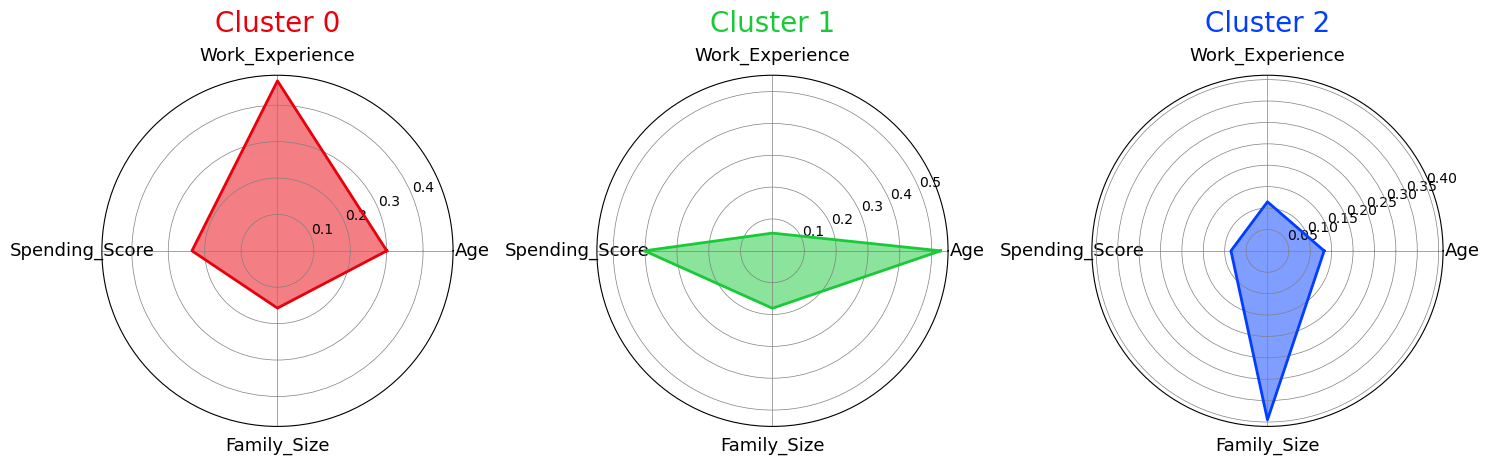

In [38]:
# calculate the means of numerical features for each cluster
cluster_means = df_normalized.groupby('KMeans_Labels')[num_features].mean()

# prepare the angles for the radar chart
angles = np.linspace(0, 2 * np.pi, len(num_features), endpoint=False).tolist()
angles += angles[:1]  # Complete the loop


fig, axes = plt.subplots(1, 3, figsize=(15, 10), subplot_kw=dict(polar=True))

# setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

# fill in data for each cluster
for i, ax in enumerate(axes):
    data = cluster_means.loc[i].tolist()
    data += data[:1]  # complete the loop for the radar chart
    
    ax.fill(angles, data, color=colors[i], alpha=0.5)
    ax.plot(angles, data, color=colors[i], linewidth=2, linestyle='solid')
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(num_features, fontsize=13)
    
    ax.set_title(f'Cluster {i}', size=20, color=colors[i], y=1.1)
    ax.grid(color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()

**Cluster 0:**
- This cluster has a moderate level of age on average, indicating a middle-aged group.
- Customers in this cluster have prominently work experience compared to the other two clusters, suggesting these individuals are well-established in their careers.
- A relatively small family size of around 2.3, typical of young families or couples possibly with one child.
- Moderate spending score of 1.47, which might indicate a balanced approach to budgeting, preferring value for money rather than splurging.

**Cluster 1:**
- Older, with an average age of about 55 years, suggesting individuals who are nearing retirement or are already retired.
- Surprisingly lowe aveage work experience of less than 1 year. This might indicate recent re-entry into the workforce, perhaps individual works or consultancy roles post-retirement.
- Average family size of 2.4, potentially indicating empty nesters whose children have recently moved out.
- The highest spending score among the clusters, suggesting that despite lower work expierence, they have sufficient disposable income, possibly from savings, pensions, or investments.

**Clsuter 2:**
- Significantly younger, with an average age of about 27 years, indicating young adults.
- Average of 1.6 years of work experience, suggesting that they are relatively new to the workforce, possibly in early career stages.
- Noticeably larger family size, averaging 4 members,likely including multiple childre or extended family living together.
- Lowest spending score of 1.17, which could reflect a more cautious approach to financial management due to early career status and larger family responsibilities.

## Categorical Features Analysis

Since we do not have any documentations on the `Var_1` feature, we are not including it in the analysis.

In [40]:
df_original.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,KMeans_Labels
0,Male,No,22,No,Healthcare,1.000000,1,4.0,Cat_4,2
1,Female,Yes,38,Yes,Engineer,2.619777,2,3.0,Cat_4,0
2,Female,Yes,67,Yes,Engineer,1.000000,1,1.0,Cat_6,1
3,Male,Yes,67,Yes,Lawyer,0.000000,3,2.0,Cat_6,1
4,Female,Yes,40,Yes,Entertainment,2.619777,3,6.0,Cat_6,2


In [72]:
# list of categorical features, dropping `Var_1`
cat_features = df_original.drop(columns='Var_1').select_dtypes(include='object').columns
cat_features

Index(['Gender', 'Ever_Married', 'Graduated', 'Profession'], dtype='object')

Gender,Female,Male
KMeans_Labels,,
0,0.517916,0.482084
1,0.426189,0.573811
2,0.433074,0.566926


Ever_Married,No,Yes
KMeans_Labels,,
0,0.439615,0.560385
1,0.156269,0.843731
2,0.799575,0.200425


Graduated,No,Yes
KMeans_Labels,,
0,0.275713,0.724287
1,0.249949,0.750051
2,0.700425,0.299575


Profession,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
KMeans_Labels,,,,,,,,,
0,0.386530,0.090577,0.098540,0.136364,0.059390,0.099867,0.077969,0.018248,0.032515
1,0.413012,0.064649,0.082149,0.122298,0.098415,0.021001,0.010500,0.161417,0.026560
2,0.109419,0.121459,0.084632,0.086756,0.041785,0.476983,0.014873,0.001771,0.062323


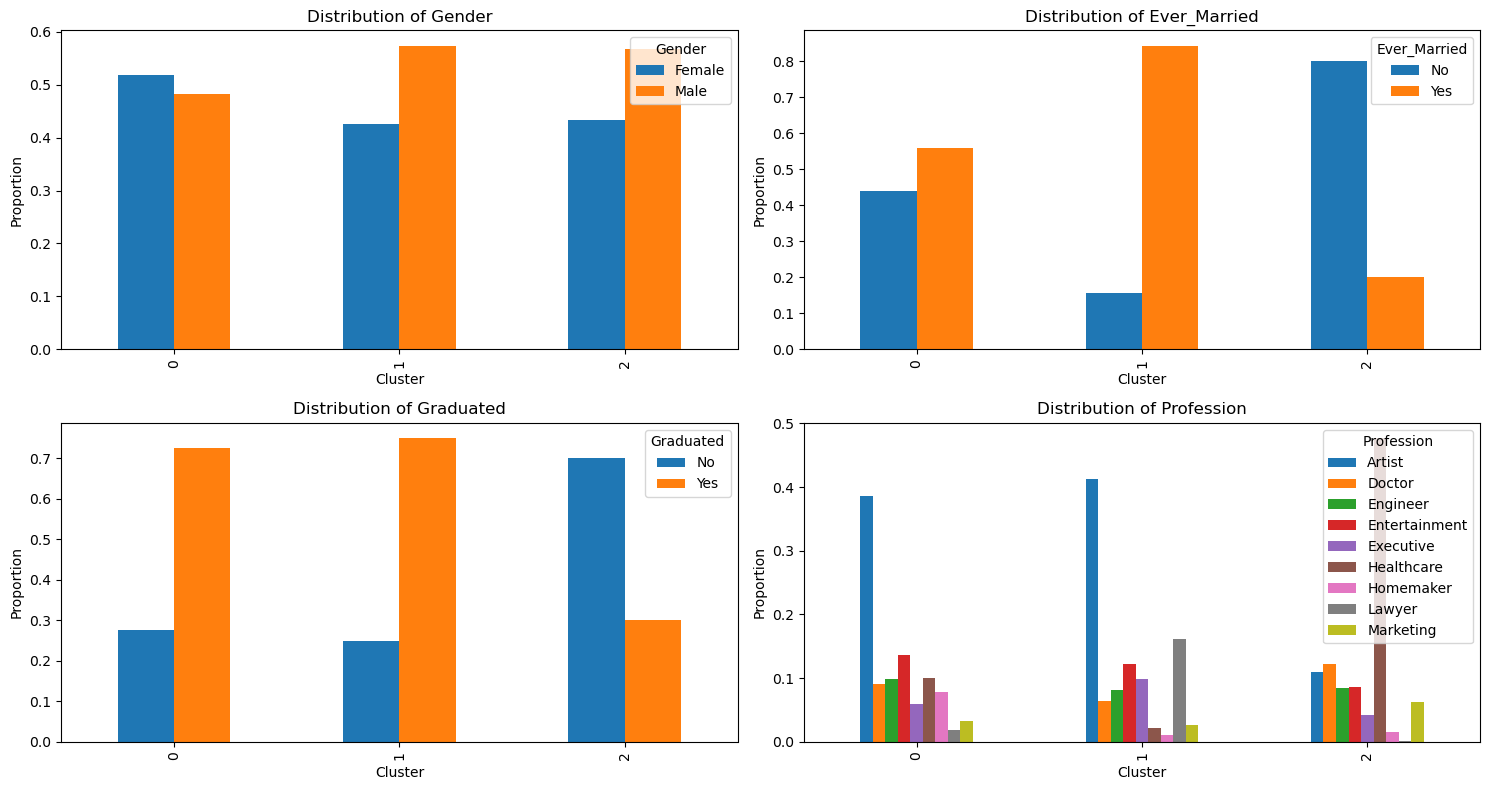

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))  
axes = axes.flatten()

for i, col in enumerate(cat_features):
    
    # aggregate categorical data
    ct = pd.crosstab(df_original['KMeans_Labels'], df_original[col], normalize='index')

    display(ct)
    
    ax = axes[i]  
    
    ct.plot(kind='bar', stacked=False, ax=ax)  
    ax.set_title(f'Distribution of {col}')
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Cluster')


plt.tight_layout()
plt.show()

**Cluster 0:**
- Nearly even split between two genders, female (51.79%) and male (48.21%), indicating no strong gender dominance.
- More than half (56%) have been married, suggestig this cluster might consist of individuals who are possibly in a more stable phase of their personal lives.
- A significant majority (72.43%) have graduated, indicating a well-educated group.
- Artist (38.65%) and Entertainment (13.64%) are notably prevalent, alongside fair representations in Engineering (9.85%) and Healthcare (9.99%).This suggests a cluster with creative professionals as well as some technical and healthcare workers.

**Cluster 1:**
- Predominantly male (57.38%).
- Highly married (84.37%), the highest among all clusters.
- Similar to Cluster 0, a large majority (75.01%) have graduated.
- Artist (41.30%) and Lawyer (16.14%) stand out, indicating a cluster of highly professional individuals. Also includes Executives (9.84%) and Entertainment (12.23%), suggesting roles that require advanced education and decision-making capabilities.

**Clsuter 2:**
- Also male dominant (56.69%).
- Predominantly not married (79.96%), which is quite distinctive compared to the other clusters.
- Majority have not graduated (70.04%), indicating a cluster with lower educational attainment, or maybe the majority of customers from this cluster is still in school.
- Dominated by Healthcare workers (47.70%), which might not require advanced degrees for all positions. Lower percentages in traditional professions that require higher education like Lawyer (0.18%) and Executive (4.18%).

## Profiling

**Cluster 0: Seasoned Mid-Career Individuals**
- **Demographics**: Comprised mainly of middle-aged people, often with small families, such as young couples or families with one child.
- **Economic Profile**: With a moderate spending score and solid work experience, this group demonstrates financial stability but avoids lavish spending. They typically seek out vehicles that are both practical and dependable, offering a good balance of cost and quality.
- **Professional Background**: This cluster includes a mix of creative professionals like artists and entertainers, as well as technical and healthcare workers, indicating a preference for cars that combine style with functionality. They likely favor cars with distinct designs that also serve well for daily commutes and family trips.
<br>

**Cluster 1: Elder Professionals and Retirees**
- **Demographics**: Generally older individuals, including retirees or those close to retirement, whose children have moved out.
- **Economic Profile**: Despite a recent decrease in work experience, this cluster shows the highest spending scores, suggesting they have substantial disposable income from sources like savings or retirement plans. They tend to prefer luxury or higher-end vehicles.
- **Professional Background**: Predominantly made up of high-level professionals such as lawyers and executives, this group leans towards luxury vehicle brands that provide enhanced comfort, prestige, and cutting-edge features.
<br>

**Cluster 2: Emerging Young Professionals**
- **Demographics**: Largely younger adults, often with large or extended families, which might require vehicles with more space.
- **Economic Profile**: Exhibits the lowest spending scores, indicative of a conservative approach to spending, likely influenced by early career stages and significant family obligations.
- **Professional Background**: A notable presence of healthcare professionals and those with generally lower levels of formal education points to a preference for vehicles that are affordable, durable, and efficient.

## Business Recommendations

**Cluster 0: Established Mid-Career Professionals**
- **Marketing Emphasis**: Dependability and cost-efficiency.
- **Tactics**:
    - `Content Strategy`: Produce articles and video content that highlights the dependable performance and economical advantages of owning mid-level sedans or crossovers.
    - `Precision Advertising`: Deploy advertisements on digital platforms and social media that focus on the sophisticated yet functional design of cars ideal for modest-sized families or routine commuting.
    - `Strategic Alliances`: Forge partnerships with corporate entities and professional associations to provide special offers or organize exclusive test-driving sessions.
    - `Rewards Initiatives`: Create rewards programs that encourage ongoing loyalty and referrals, targeting this group’s preference for pragmatic rewards.
<br>

**Cluster 1: Senior Professionals and Retirees**
- **Marketing Emphasis**: Luxry, comfort, and status
- **Tactics**:
    - `Customized Messaging`: Execute a targeted marketing drive through emails or postal service that showcases the opulent features, unmatched comfort, and cutting-edge safety features of premium models.
    - `Exclusive Events`: Arrange special events at showrooms where prospective clients can firsthand experience the elegance and sophistication of luxury models.
    - `Enhanced Buying Experience`: Improve the buying process to be extremely tailored and customer-focused, mirroring the upscale nature of the vehicles.
    - `Outreach to Retiree Communities`: Set up demonstrations and test drives in communities frequented by retirees to better engage this demographic.
<br>

**Cluster 2: Emerging Young Professionals and Adults**
- **Marketing Emphasis**: Cost efficiency, spaciousness, and minimal upkeep.
- **Tactics**:
    - `Digital Campaigns`: Utilize popular social media channels among the youth to showcase the cost-effectiveness and functionality of compact and family-oriented vehicles.
    - `Appealing Financing Deals`: Highlight enticing financing terms, including low rates and adaptable payment schemes, essential for this financially aware audience.
    - `Community Involvement`: Engage in local events frequented by families to provide test drives and display the versatility and efficiency of the recommended models.
    - `Partnerships with Influencers`: Work with social media influencers who align with young individuals and families to underscore the practical advantages and suitability of the vehicles for their lifestyles.